# Classification Main-Pied

## Apprentissage sur stimulation; Test sur imagination

Cerveau Entier - Parcellation BASC (444 régions)

Tous les sujets - SVM Linéaire


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from nilearn.plotting import plot_stat_map
%matplotlib inline
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPPlot import plot_selectedregions

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import data
names='ap','as','bh','bi','boh','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
smt='ss'
fold_g = 'F:/IRM_Marche/'
label_i=np.loadtxt(fold_g+'label_main.txt','S12')
blocks_i=np.loadtxt(fold_g+'block_main.txt','int')

roi=np.zeros([0,444])
#rest=np.zeros([0,444])
label=np.zeros([0,3])
blocks=np.array([])
for n in names:
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    #rest_filename=  fold_g+'mni4060/asymroirest_'+smt+'_'+n+'.npz'  
    tmproi=np.load(sim_filename)['roi']
    #tmprest=np.load(rest_filename)['roi']
    roi=np.concatenate((roi,tmproi))
    #rest=np.concatenate((rest,tmprest))
    label=np.append(label,label_i,axis=0)
    blocks=np.append(blocks,blocks_i) 
    
# Remove first volumes per block    
index=[]
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        index.append(x)
    elif label[x,0]!=label[x-2,0]:
        index.append(x)
        
label=np.delete(label,index,0)
blocks=np.delete(blocks,index,0)
roi=np.delete(roi,index,0)

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= condition_cat==condition_out
block=blocks[condition_mask]
y=label[condition_mask]
cond=roi[condition_mask]
   
train_mask= y[:,0]==b'stim'
test_mask= y[:,0]==b'imag'
y_train=y[train_mask,1]
y_test=y[test_mask,1]
roi_train=cond[train_mask]#   
roi_test=cond[test_mask]
block=block[train_mask]

## Data indiv

index_i=[]
nb_s=len(names)
for x in range(label_i.shape[0]):
    if label_i[x,0]!=label_i[x-1,0]:
        index_i.append(x)
    elif label_i[x,0]!=label_i[x-2,0]:
        index_i.append(x)
        
label_i=np.delete(label_i,index_i,0)
blocks_i=np.delete(blocks_i,index_i,0)

condition_cat_i = np.logical_or(label_i[:,1] == b'foot', label_i[:,1] == b'hand')
condition_out_i=np.logical_not(label_i[:,2]== b'des')
condition_mask_i= condition_cat_i==condition_out_i
block_i=blocks_i[condition_mask_i]
y_i=label_i[condition_mask_i]

   
train_mask_i= y_i[:,0]==b'stim'
test_mask_i= y_i[:,0]==b'imag'
y_train_i=y_i[train_mask_i,1]
y_test_i=y_i[test_mask_i,1]
  
block_i=block_i[test_mask_i]

In [4]:
# Prepare ploting
scaler = preprocessing.StandardScaler()
svm= SVC(C=0.1, kernel="linear")  
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']
brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory_level=1, verbose=0,
                           detrend=True, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels'
                           )
masker.fit()

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


NiftiLabelsMasker(background_label=0, detrend=True, high_pass=0.01,
         labels_img='C:\\Users\\mmenoret/nilearn_data\\basc_multiscale_2015\\template_cambridge_basc_multiscale_nii_asym\\template_cambridge_basc_multiscale_asym_scale444.nii.gz',
         low_pass=None,
         mask_img=<nibabel.nifti1.Nifti1Image object at 0x00000000047C6438>,
         memory=Memory(cachedir=None), memory_level=1,
         resampling_target='labels', sessions=None, smoothing_fwhm=None,
         standardize=False, t_r=2.28, verbose=0)

### Classification seulement sur regions BASC motrices

In [5]:
#imag_region=np.fromfile('F:/IRM_Marche/harv_imag_basc444asym.np',dtype=int)

#motor_region=np.fromfile('F:/IRM_Marche/harv_motorlarge_basc444asym.np',dtype=int)
#motor_region=np.fromfile('F:/IRM_Marche/masquesROI/reg_motorC_basc444asym.np','int')
motor_region=np.fromfile('F:/IRM_Marche/masquesROI/reg_whole70_basc444asym.np','int')
#motor_region=np.fromfile('F:/IRM_Marche/masquesROI/reg_control200_basc444asym.np','int')
#motor_region_index=np.fromfile('F:/IRM_Marche/motorregion57_basc444asym.np',dtype=int)
#motor_region_index=np.unique(np.hstack((imag_region,motor_region)))

motor_region_index=motor_region
print(motor_region_index,len(motor_region_index))

[  1  10  11  16  20  22  23  27  28  29  30  35  38  44  46  47  50  52
  53  57  58  65  67  68  69  70  75  78  80  83  84  86  88  89  91  92
  95  99 101 104 107 108 110 111 113 120 121 122 124 126 129 131 133 134
 135 136 137 138 139 141 142 144 147 148 149 150 151 154 155 156 160 161
 163 164 172 176 178 179 182 184 186 189 191 192 195 199 200 201 202 204
 206 208 209 212 213 214 216 218 219 220 225 228 230 233 239 244 247 249
 252 254 257 260 264 266 267 268 270 272 273 275 277 279 280 281 282 283
 284 285 287 294 296 299 301 302 303 306 308 310 311 312 316 320 324 325
 326 330 331 336 343 344 351 358 363 365 368 369 371 372 374 378 381 387
 391 392 397 398 400 401 403 413 414 418 421 422 424 425 428 430 432 435
 437 439 441 443] 184


In [8]:
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])
roi_m_test=roi_test[:,motor_region_index-1]
roi_m_train=roi_train[:,motor_region_index-1]
pipeline.fit(roi_m_test, y_test)
coef_imag = pipeline.named_steps['classif_name'].coef_

pipeline.fit(roi_m_train, y_train)
coef_imp = pipeline.named_steps['classif_name'].coef_


Accuracy Train:IMAG Test: STIM: 71.1670480549 %
Accuracy Train:STIM Test:IMAG: 56.941266209 %


In [75]:
cv = LeaveOneLabelOut(block)
score_cv = cross_val_score(pipeline, roi_m_train, y_train,cv=cv)
print('STIM only CV',score_cv.mean())
score_cv = cross_val_score(pipeline, roi_m_test, y_train,cv=cv)
print('IMAG only CV',score_cv.mean())

STIM only CV 0.604612376352
IMAG only CV 0.561536691971


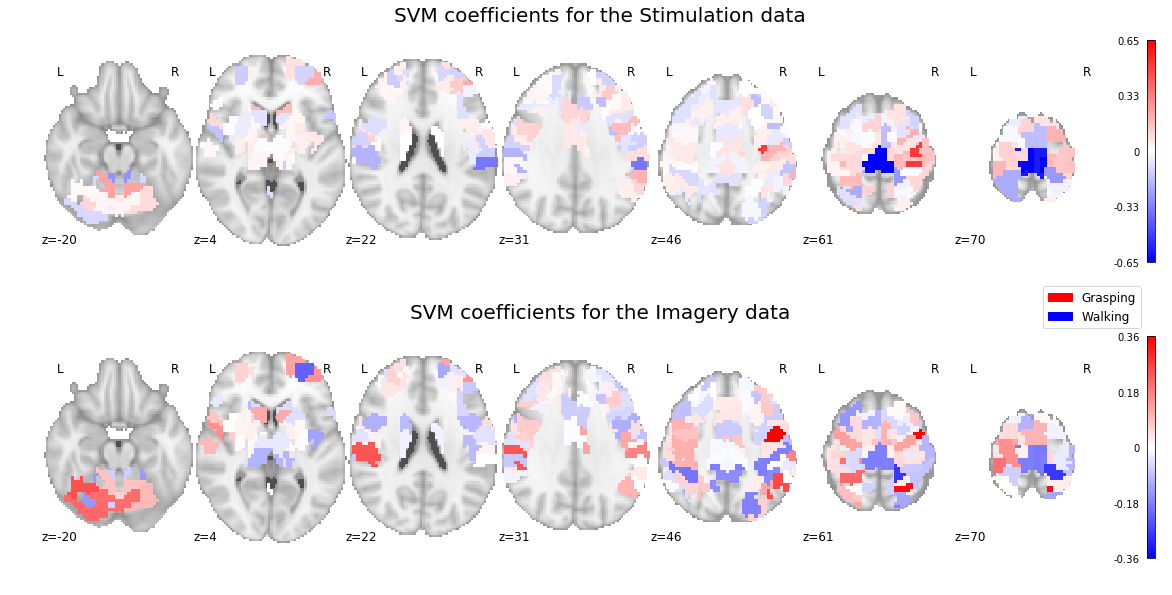

In [69]:
# Plot resulting weights of the SVM & selected regions

coef_tr_imp=np.zeros([1,444])
coef_tr_imag=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    coef_tr_imp[0,n-1]=coef_imp[0,i]
    coef_tr_imag[0,n-1]=coef_imag[0,i]
from nilearn.plotting import plot_stat_map
weight_img_trimp = masker.inverse_transform(coef_tr_imp)
weight_img_trimag = masker.inverse_transform(coef_tr_imag)

import matplotlib.pylab as plt
figure, (axes1, axes2) = plt.subplots(2, 1,figsize=(20,10))
plot_stat_map(weight_img_trimp, display_mode='z',cmap='bwr',axes=axes1,cut_coords=[-20,4,22,31,46,61,70])
axes1.set_title('SVM coefficients for the Stimulation data',fontdict={'fontsize': 20})

plot_stat_map(weight_img_trimag, display_mode='z',cmap='bwr',axes=axes2,cut_coords=[-20,4,22,31,46,61,70])
axes2.set_title('SVM coefficients for the Imagery data',fontdict={'fontsize': 20})
#plot_stat_map(weight_img_trimag,cmap='bwr')#, cut_coords=[-6, 6, 60])
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Grasping')
blue_patch= mpatches.Patch(color='blue', label='Walking')
plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(0, 1.25),fontsize=12)
figure.savefig('C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/figure1.tiff')

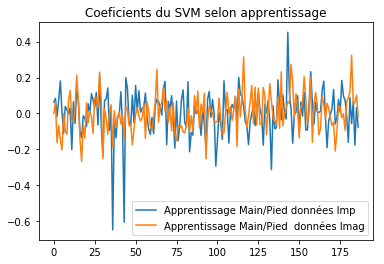

In [138]:
import matplotlib.pyplot as plt
plt.plot(coef_imp.T,label='Apprentissage Main/Pied données Imp')
plt.plot(coef_imag.T,label='Apprentissage Main/Pied  données Imag')
plt.title('Coeficients du SVM selon apprentissage')
plt.legend()

Visualisation des régions qui sont communes entre les deux SVM

In [83]:
coef_imag.sum()

-0.3302237217296371

0.0483253675056
0.064718756626
0.059392556006
0.0507311663287
(20,)
(18,)


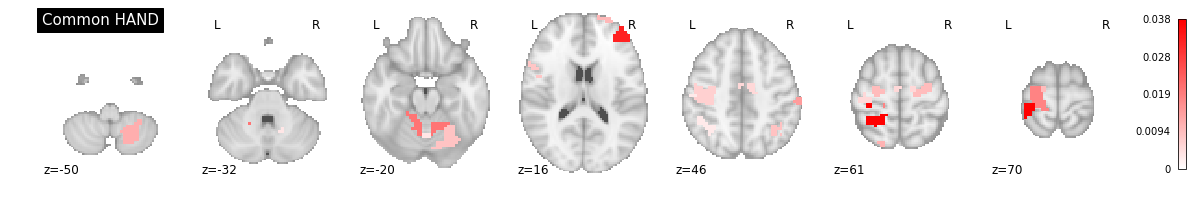

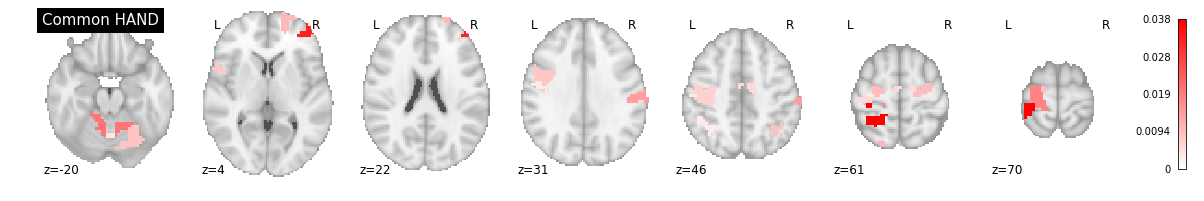

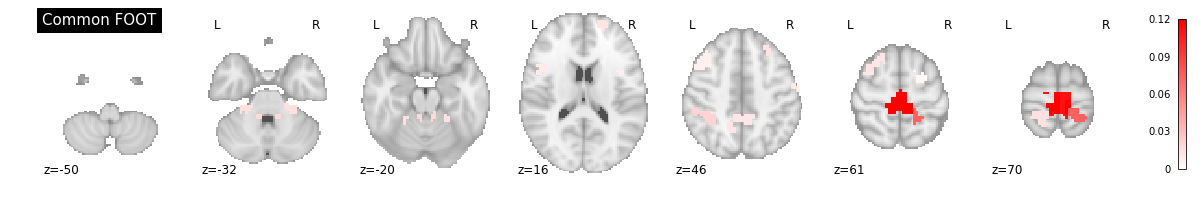

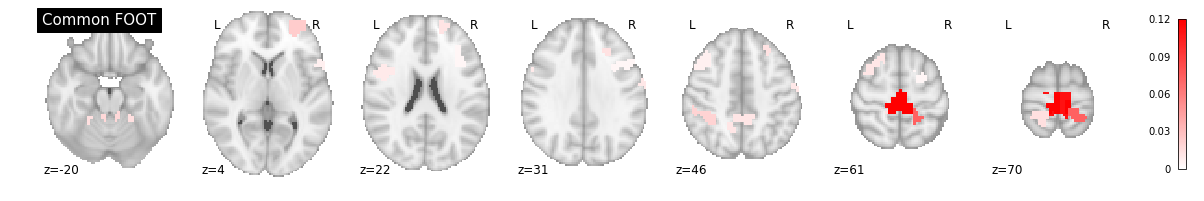

In [51]:
import matplotlib.pyplot as plt

def select_perc(array,perc):
    array_sum=np.abs(array.sum())
    #print(array_sum)
    #print(perc*array_sum)
    index_sorted=np.argsort(np.abs(array))[::-1]
    array_sorted=np.abs(array[index_sorted])
    cumulative = np.cumsum(array_sorted)
    #plt.figure()
   # plt.plot(cumulative)
    idx = (np.abs(cumulative-perc*array_sum)).argmin()
    #plt.axvline(idx,color='k')
    return idx,array_sorted[idx]
        
def select_max_r(array,sign,perc):
    new_array=array.copy()
    if 'p' in sign:
        array_sign=array.T[array.T>0]
        nb,th=select_perc(array_sign,perc)
        new_array[array<th]=0
    if 'n' in sign:
        array_sign=array.T[array.T<0]
        nb,th=select_perc(array_sign,perc)
        new_array[array>-th]=0
    print(th)
    return new_array
    
        
perc=0.85
coef_imp_p=select_max_r(coef_imp,'p',perc)
coef_imp_n=select_max_r(coef_imp,'n',perc)
coef_imag_p=select_max_r(coef_imag,'p',perc)
coef_imag_n=select_max_r(coef_imag,'n',perc)
coef_tr_imp_pos=np.zeros([1,444])
coef_tr_imag_pos=np.zeros([1,444])
coef_tr_imp_neg=np.zeros([1,444])
coef_tr_imag_neg=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    coef_tr_imp_pos[0,n-1]=coef_imp_p[0,i]
    coef_tr_imp_neg[0,n-1]=-coef_imp_n[0,i]
    coef_tr_imag_pos[0,n-1]=coef_imag_p[0,i]
    coef_tr_imag_neg[0,n-1]=-coef_imag_n[0,i]
from nilearn.plotting import plot_stat_map
weight_img_trimp_pos = masker.inverse_transform(coef_tr_imp_pos)
weight_img_trimag_pos = masker.inverse_transform(coef_tr_imag_pos)
weight_img_trimp_neg = masker.inverse_transform(coef_tr_imp_neg)
weight_img_trimag_neg = masker.inverse_transform(coef_tr_imag_neg)
#plot_stat_map(weight_img_trimp_pos, title='Regions',display_mode='z',cut_coords=[-50,-32,-20,16,46,61,70],cmap='bwr')
#plot_stat_map(weight_img_trimag_pos, title='Regions',display_mode='z',cut_coords=[-50,-32,-20,16,46,61,70],cmap='bwr')
#plot_stat_map(weight_img_trimp_neg, title='Regions',display_mode='z',cut_coords=[-50,-32,-20,16,46,61,70],cmap='bwr')
#plot_stat_map(weight_img_trimag_neg, title='Regions',display_mode='z',cut_coords=[-50,-32,-20,16,46,61,70],cmap='bwr')

# Commune
coef_common_pos=coef_tr_imp_pos.T*coef_tr_imag_pos.T
print(np.nonzero(coef_common_pos)[0].shape)
weight_common_pos = masker.inverse_transform(coef_common_pos.T)
plot_stat_map(weight_common_pos, title='Common HAND',display_mode='z',cmap='bwr')
plot_stat_map(weight_common_pos, title='Common HAND',display_mode='z',cut_coords=[-20,4,22,31,46,61,70],cmap='bwr')
coef_common_neg=coef_tr_imp_neg.T*coef_tr_imag_neg.T
print(np.nonzero(coef_common_neg)[0].shape)
weight_common_neg = masker.inverse_transform(coef_common_neg.T)
plot_stat_map(weight_common_neg, title='Common FOOT',display_mode='z',cmap='bwr')
plot_stat_map(weight_common_neg, title='Common FOOT',display_mode='z',cut_coords=[-20,4,22,31,46,61,70],cmap='bwr')
#weight_img_trimp_pos.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMP_coefPOS_th90.nii')
#weight_img_trimag_pos.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMAG_coePOS_th90.nii')
#weight_img_trimp_neg.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMP_coefNEG_th90.nii')
#weight_img_trimag_neg.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMAG_coefNEG_th90.nii')
#weight_common_pos.to_filename('F:/IRM_Marche/result/compHANDFOOT_COMMON_coefPOS_th90.nii')
#weight_common_neg.to_filename('F:/IRM_Marche/result/compHANDFOOT_COMMON_coefNEG_th90.nii')

(38,)


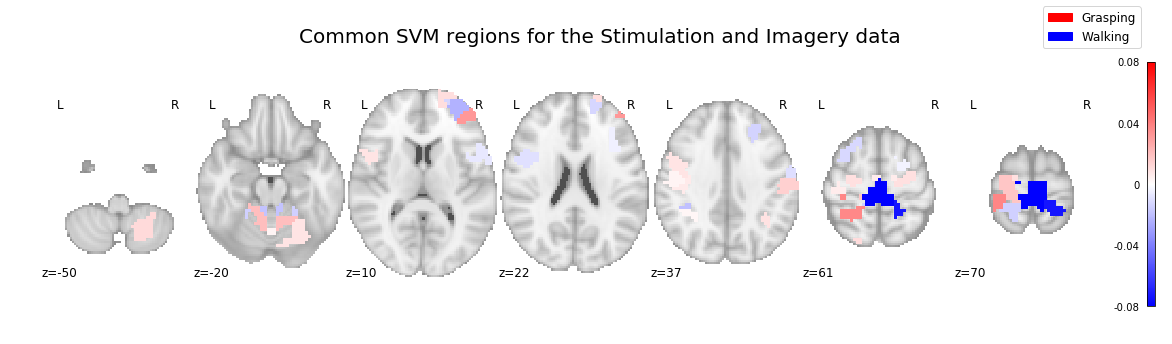

In [70]:
# Commune
coef_common=(coef_tr_imp_pos.T*coef_tr_imag_pos.T)-(coef_tr_imp_neg.T*coef_tr_imag_neg.T)
print(np.nonzero(coef_common)[0].shape)
weight_common = masker.inverse_transform(coef_common.T)

figure, (axes1) = plt.subplots(1, 1,figsize=(20,5))
plot_stat_map(weight_common,display_mode='z',cmap='bwr',axes=axes1,vmax=0.08,cut_coords=[-50,-20,10,22,37,61,70])
axes1.set_title('Common SVM regions for the Stimulation and Imagery data',fontdict={'fontsize': 20})
plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(0, 1.25),fontsize=12)
figure.savefig('C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/figure2.tiff')

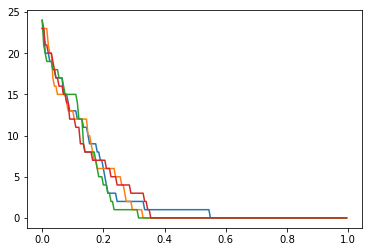

In [136]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

imp_left_pos=[]
imp_left_neg=[]
imag_left_pos=[]
imag_left_neg=[]
ths=np.arange(0,1,0.005)
for th in ths:
    imp_left_pos.append((coef_imp>=th).sum())
    imp_left_neg.append((coef_imp<=(-th)).sum())
    imag_left_pos.append((coef_imag>=th).sum())
    imag_left_neg.append((coef_imag<=(-th)).sum())



plt.plot(ths,np.array(imp_left_pos))
plt.plot(ths,np.array(imp_left_neg))
plt.plot(ths,np.array(imag_left_pos))
plt.plot(ths,np.array(imag_left_neg))

per=0.25
th_imp_pos=ths[find_nearest(np.array(imp_left_pos),per*imp_left_pos[0])]
th_imp_neg=ths[find_nearest(np.array(imp_left_neg),per*imp_left_neg[0])]
th_imag_pos=ths[find_nearest(np.array(imag_left_pos),per*imag_left_pos[0])]
th_imag_neg=ths[find_nearest(np.array(imag_left_neg),per*imag_left_neg[0])]

pos_coef_imp=coef_imp.copy()
neg_coef_imp=coef_imp.copy()
pos_coef_imag=coef_imp.copy()
neg_coef_imag=coef_imp.copy()
pos_coef_imp[coef_imp<th_imp_pos]=0
neg_coef_imp[coef_imp>-th_imp_neg]=0
new_coef_imp=pos_coef_imp+neg_coef_imp
pos_coef_imag[coef_imag<th_imag_pos]=0
neg_coef_imag[coef_imag>-th_imag_neg]=0
new_coef_imag=pos_coef_imag+neg_coef_imag


coef_tr_imp_pos=np.zeros([1,444])
coef_tr_imag_pos=np.zeros([1,444])
coef_tr_imp_neg=np.zeros([1,444])
coef_tr_imag_neg=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    coef_tr_imp_pos[0,n-1]=pos_coef_imp[0,i]
    coef_tr_imag_pos[0,n-1]=pos_coef_imag[0,i]
    coef_tr_imp_neg[0,n-1]=-neg_coef_imp[0,i]
    coef_tr_imag_neg[0,n-1]=-neg_coef_imag[0,i]
from nilearn.plotting import plot_stat_map
weight_img_trimp_pos = masker.inverse_transform(coef_tr_imp_pos)
weight_img_trimag_pos = masker.inverse_transform(coef_tr_imag_pos)
weight_img_trimp_neg = masker.inverse_transform(coef_tr_imp_neg)
weight_img_trimag_neg = masker.inverse_transform(coef_tr_imag_neg)
#weight_img_trimp_pos.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMP_coefPOS_th.nii')
#weight_img_trimag_pos.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMAG_coefPOS_th.nii')
#weight_img_trimp_neg.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMP_coefNEG_th.nii')
#weight_img_trimag_neg.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMAG_coefNEG_th.nii')


25
17


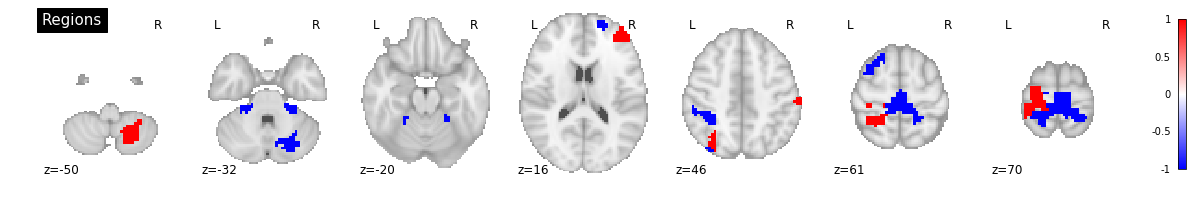

In [13]:
val=0.1
above=np.logical_and(abs(coef_imp)>val, np.abs(coef_imag)>val)
print(above.sum())
diff=np.sign(coef_imag)==np.sign(coef_imp)
index=np.logical_and(above,diff)
print(index.sum())

roi_index=np.zeros(coef_imp.shape)
for i in range(coef_imp.shape[1]):
    if index.T[i]:
        if np.sign(coef_imp.T[i])==1:
            roi_index.T[i]=1
        else:
            roi_index.T[i]=-1
              

roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=roi_index[0,i]
weight = masker.inverse_transform(roi)
plot_stat_map(weight, title='Regions',display_mode='z',cut_coords=[-50,-32,-20,16,46,61,70],cmap='bwr')



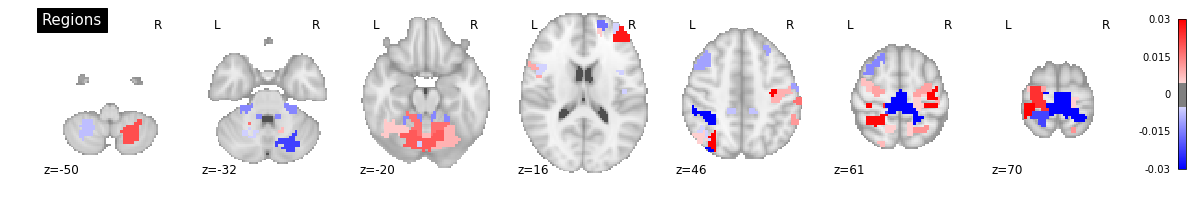

In [12]:
from sklearn.preprocessing import normalize
#nh=normalize(coef_imp)
#nf=normalize(coef_imag)
#coef_common=nh.T*nf.T
coef_common=coef_imp.T*coef_imag.T
z = coef_common[:]
for i,x in enumerate(coef_common):
    if x<=0:
        z[i]=0
    else:
        z[i]=x

for i,x in enumerate(coef_common):
    if coef_imp.T[i]<0:
        z[i]=-z[i]
z=z.T

roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=z[0,i]
weight = masker.inverse_transform(roi)
plot_stat_map(weight, title='Regions',display_mode='z',cut_coords=[-50,-32,-20,16,46,61,70],
              cmap='bwr',threshold=0.005,vmax=0.03
             )

In [155]:
roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=z[0,i]
weight = masker.inverse_transform(roi)
weight.to_filename('F:/IRM_Marche/result/compHANDFOOT_intersept_coef.nii')

In [153]:
roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=coef_imp[0,i]
weight = masker.inverse_transform(roi)
weight.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainSTIM_coef.nii')

In [154]:
roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=coef_imag[0,i]
weight = masker.inverse_transform(roi)
weight.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMAG_coef.nii')

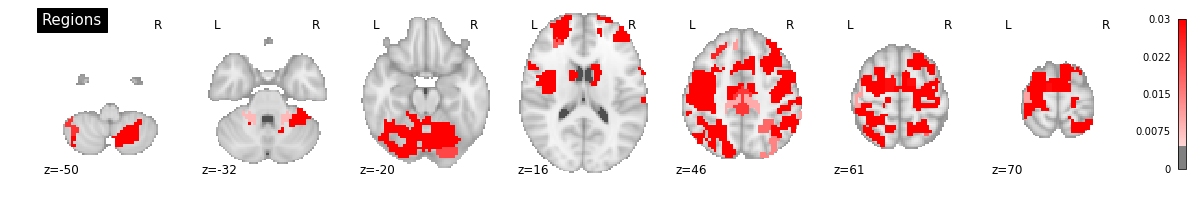

In [37]:
from sklearn.preprocessing import normalize
z = coef_imag.copy().T
for i,x in enumerate(z):
    if x<0:
        z[i]=0
    else:
        z[i]=x
z=z.T

roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=z[0,i]
weight = masker.inverse_transform(roi)
plot_stat_map(weight, title='Regions',display_mode='z',cut_coords=[-50,-32,-20,16,46,61,70],
              cmap='bwr',threshold=0.005,vmax=0.03
             )
weight.to_filename('F:/IRM_Marche/result/compHANDFOOT_trainIMAG_coefPOS.nii')

In [22]:
coef_imp.copy

<function ndarray.copy>

In [142]:
### Permutation block
pipeline.fit(roi_m_train, y_train)
prediction = pipeline.predict(roi_m_test)  
result_tr_stim=accuracy_score(prediction,y_test)

pipeline.fit(roi_m_test, y_test)
prediction = pipeline.predict(roi_m_train)  
result_tr_imag=accuracy_score(prediction,y_train)

nb_p=1000
null_result_tr_stim=np.zeros(nb_p)
null_result_tr_imag=np.zeros(nb_p)
nb_s=len(names)
ncond=['foot','hand']
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    # shuffle block number
    for suj in range(nb_s):
        xncond=np.random.permutation(ncond)
        suj_train_random=np.append(np.full(57,xncond[0],dtype='S12'),np.full(57,xncond[1],dtype='S12'))
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline.fit(roi_m_train, y_train_random)
    prediction = pipeline.predict(roi_m_test) 
    null_result_tr_stim[i]=accuracy_score(prediction,y_test)
    
    pipeline.fit(roi_m_test, y_train_random)
    prediction = pipeline.predict(roi_m_train) 
    null_result_tr_imag[i]=accuracy_score(prediction,y_train)

sign_tr_stim=(null_result_tr_stim>=result_tr_stim).sum()/nb_p
sign_tr_imag=(null_result_tr_imag>=result_tr_imag).sum()/nb_p
print('Train Stim',sign_tr_stim,'Train Imag',sign_tr_imag,)

Train Stim 0.0 Train Imag 0.0
